### Implementing Long Short-Term Memory to detect and classify Parkinsons' Freezing of Gait types in time series data

In [1]:
using Pkg

# Pkg.add("CSV")
# Pkg.add("NNlib")
# Pkg.add("DataFrames")
# Pkg.add("Distributions")
# Pkg.add("ResumableFunctions")
# Pkg.add("Flux")


In [24]:
using Flux
using Flux: @epochs, batch, throttle

using CSV
using Plots
using NNlib
using Random
using DataFrames
using Distributions
using ResumableFunctions

In [3]:
parkinson = CSV.read("./filtered_data.csv", DataFrame)

Row,Id,Subject,Visit,Test,Medication,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,event
,String15,String7,Int64,Int64,String3,Int64,Float64,Float64,Float64,Int64,Int64,Int64,String7
1,009ee11563,f62eec,4,2,on,0,-9.4173,0.767819,-1.75824,0,0,0,Normal
2,009ee11563,f62eec,4,2,on,1,-9.4251,0.768246,-1.75058,0,0,0,Normal
3,009ee11563,f62eec,4,2,on,2,-9.41995,0.779039,-1.74259,0,0,0,Normal
4,009ee11563,f62eec,4,2,on,3,-9.42127,0.772523,-1.74651,0,0,0,Normal
5,009ee11563,f62eec,4,2,on,4,-9.42811,0.777142,-1.75555,0,0,0,Normal
6,009ee11563,f62eec,4,2,on,5,-9.42602,0.774812,-1.76021,0,0,0,Normal
7,009ee11563,f62eec,4,2,on,6,-9.42569,0.768126,-1.7736,0,0,0,Normal
8,009ee11563,f62eec,4,2,on,7,-9.43509,0.765923,-1.76937,0,0,0,Normal
9,009ee11563,f62eec,4,2,on,8,-9.43209,0.770584,-1.77557,0,0,0,Normal


In [27]:
@resumable function data_loader(parkinson_dataframe, num_sequences, num_selected_sequences, batch_size; labels=["StartHesitation", "Turn", "Walking", "Normal"])
    @assert num_selected_sequences <= num_sequences
    
    pdf = deepcopy(parkinson_dataframe)
    
    sequences = collect(1:num_sequences)
    shuffle!(sequences)

    # Sending to the model
    for i in 1:num_selected_sequences
        # if benne van a random generalt elemek tombunkben
        x = hcat(
            pdf[!, "AccV"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size],
            pdf[!, "AccML"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size],
            pdf[!, "AccAP"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size]
        )
    
        y = Flux.onehotbatch(pdf[!, "event"][sequences[i] * batch_size : sequences[i] * batch_size + batch_size], labels)
        
        @yield x, y
    end
end

data_loader (generic function with 1 method)

In [5]:
function init_params(in::Integer, out::Integer; mean=0.0, std=1.0)
    [
        in, out,
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wf
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wi
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wc
        rand(Truncated(Normal(mean, std), -1, 1), out), # Wo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bf
        rand(Truncated(Normal(mean, std), -1, 1), out), # bi
        rand(Truncated(Normal(mean, std), -1, 1), out), # bc
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo
        rand(Truncated(Normal(mean, std), -1, 1), out), # bo

        # both the Long-Term and Short-Term memories are initialized with 0 values
        zeros(out),  # c
        zeros(out),  # h
        true # update_memory
    ]
end


init_params (generic function with 1 method)

In [6]:
# implementing the forwarding method which is used in the Chaining process
function forward(x, lstm)

    for i in 1:size(x, 1)
        long_remember_percent = NNlib.sigmoid_fast((lstm.c .* lstm.wlr1) + (x[i, :] .* lstm.wlr2) + lstm.blr1)
        potential_remember_percent = NNlib.sigmoid_fast((lstm.h .* lstm.wpr1) + (x[i, :] .* lstm.wpr2) + lstm.bpr1)
        potential_memory = NNlib.tanh_fast((lstm.c .* lstm.wp1) + (x[i, :] .* lstm.wp2) + lstm.bp1)
        updated_long_memory = (lstm.c .* long_remember_percent) + (potential_memory .* potential_remember_percent)
        output_percent = NNlib.sigmoid_fast((lstm.h .* lstm.wo1) + (x[i, :] .* lstm.wo2) + lstm.bo1)
        updated_short_memory = NNlib.tanh_fast(updated_long_memory) .* output_percent

        # updating the memory
        if lstm.update_memory
            lstm.c, lstm.h = updated_long_memory, updated_short_memory
        end
    end

    lstm.c
end

forward (generic function with 1 method)

In [7]:
# custom Long Short-Term Memory layer
mutable struct LSTM
    # input and output size of the layer
    in::Integer
    out::Integer

    wlr1::Vector{Float32}
    wlr2::Vector{Float32}
    blr1::Vector{Float32}

    wpr1::Vector{Float32}
    wpr2::Vector{Float32}
    bpr1::Vector{Float32}

    wp1::Vector{Float32}
    wp2::Vector{Float32}
    bp1::Vector{Float32}

    wo1::Vector{Float32}
    wo2::Vector{Float32}
    bo1::Vector{Float32}


    # cell state (aka. long-term memory) and hidden state (aka. short-term memory)
    c::Vector{Float32}
    h::Vector{Float32}

    # prevents the model from modifying the memory state in case of testing and loss calculation
    # it needs to be set explicitely before and after calling the model(x) funtion
    update_memory::Bool
end

In [8]:
# defining the constructor
LSTM(in::Integer, out::Integer) = LSTM(init_params(in, out)...)

LSTM

In [9]:
# Overload call, so the object can be used as a function
(lstm::LSTM)(x) = forward(x, lstm)

In [10]:
# creating a functor from the struct, so that the training can optimize its parameters
Flux.@functor LSTM

In [11]:
# creating the Long Short-Term Memory layer
function LSTM((in, out)::Pair)
    LSTM(in, out) # constructor
end

LSTM

In [12]:
# explicitely defining the trainable parameters of the layer
# all the Wrights and Biases are trainable
# exceptions >> Cell State and Hidden State
# Flux.trainable(lstm::LSTM) = (lstm.Wf, lstm.Wi, lstm.Wc, lstm.Wo, lstm.bf, lstm.bi, lstm.bc, lstm.bo,)
Flux.trainable(lstm::LSTM) = (lstm.wlr1, lstm.wlr2, lstm.blr1, lstm.wpr1, lstm.wpr2, lstm.bpr1, lstm.wp1, lstm.wp2, lstm.bp1, lstm.wo1, lstm.wo2, lstm.bo1)

In [30]:
# Random generating sequences
num_sequences = 10_000
num_selected_sequences = 100
batch_size = div(size(parkinson, 1), num_sequences)

input_size = batch_size
hidden_size = 3
num_classes = 4 

model = Chain(
    LSTM(input_size => hidden_size),
    Dense(hidden_size => num_classes),
    softmax
)

;

In [31]:
function loss(x, y)
    model[1].update_memory = false
    l = Flux.crossentropy.(eachrow(model(x)'), eachrow(y'))
    model[1].update_memory = true

    mean(l)
end

optimizer = ADAM(0.001)
epochs = 50

;

In [33]:
losses = []

for epoch in 1:epochs

  epoch_loss = 0f0

  for (input, output) in data_loader(parkinson, num_sequences, num_selected_sequences, batch_size)
    grads = Flux.gradient(Flux.params(model)) do
      l = loss(input, output) 
      epoch_loss += l

      l
    end
    Flux.update!(optimizer, Flux.params(model), grads)
  end

  train_loss = epoch_loss / num_selected_sequences 
  @info "Epoch: $epoch >> Loss: $train_loss"
  append!(losses, train_loss)

end

[ Info: Epoch: 1 >> Loss: 1.2866912
[ Info: Epoch: 2 >> Loss: 1.2310929
[ Info: Epoch: 3 >> Loss: 1.1768312
[ Info: Epoch: 4 >> Loss: 1.131429
[ Info: Epoch: 5 >> Loss: 1.0873991
[ Info: Epoch: 6 >> Loss: 1.048328
[ Info: Epoch: 7 >> Loss: 1.0198815
[ Info: Epoch: 8 >> Loss: 1.0042984
[ Info: Epoch: 9 >> Loss: 0.97855407
[ Info: Epoch: 10 >> Loss: 0.936993
[ Info: Epoch: 11 >> Loss: 0.92000955
[ Info: Epoch: 12 >> Loss: 0.9160857
[ Info: Epoch: 13 >> Loss: 0.8894139
[ Info: Epoch: 14 >> Loss: 0.8725357
[ Info: Epoch: 15 >> Loss: 0.8746109
[ Info: Epoch: 16 >> Loss: 0.85781336
[ Info: Epoch: 17 >> Loss: 0.84256506
[ Info: Epoch: 18 >> Loss: 0.8448432
[ Info: Epoch: 19 >> Loss: 0.82071394
[ Info: Epoch: 20 >> Loss: 0.81263006
[ Info: Epoch: 21 >> Loss: 0.8207326
[ Info: Epoch: 22 >> Loss: 0.80191267
[ Info: Epoch: 23 >> Loss: 0.80164033
[ Info: Epoch: 24 >> Loss: 0.79091144
[ Info: Epoch: 25 >> Loss: 0.7808682
[ Info: Epoch: 26 >> Loss: 0.7838982
[ Info: Epoch: 27 >> Loss: 0.76601404
[ I

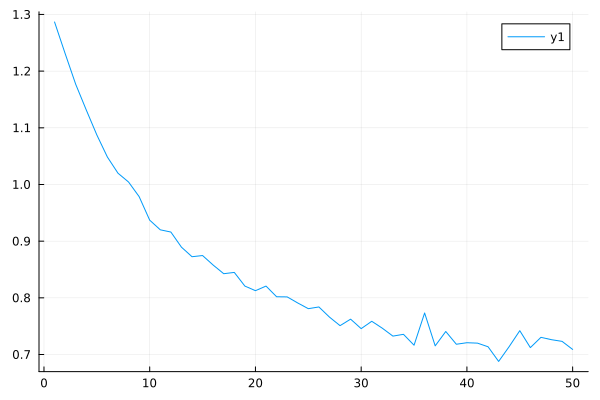

In [34]:
Plots.plot(collect(1:epochs), losses)